# Preprocessing text for embedding.


In [16]:
%config Completer.use_jedi = False

import os
from datetime import datetime
import sys
import numpy as np
import pandas as pd

import sparknlp
print(f"SparkNLP version: {sparknlp.version()}")
import pyspark.sql.functions as F
from pyspark.sql import types as T
from sparknlp.base import LightPipeline

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as tftext  # <-- need to import here f
print(f"Tensorflow version: {tf.__version__}")


import umap

try:
    import plotly
except ImportError as e:
    ! pip install plotly==4.14.3
    import plotly
import plotly.express as px
print(f"Plotly version: {plotly.__version__}")

DATA_PATH = "../data/reddit_wsb.csv"

SparkNLP version: 2.7.4
Tensorflow version: 2.4.1
Plotly version: 4.14.3


In [ ]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk"
os.environ["PATH"] = f"{os.environ['JAVA_HOME']}/bin:{os.environ['PATH']}"

# to allow importing from parent directory of notebooks folder
sys.path.append('..')

spark = sparknlp.start()

%load_ext autoreload
%autoreload 1
%aimport embedding_pipeline

# Preprocess with Spark NLP: Round 1
Will investigate my first attempt and then make any corrections.

In [266]:
%%time
# the format of the reddit data is that the string columns
# are wrapped in "s, and that internal quotes have are 
# wrapped in ""s or 's.
df = spark.read.csv(DATA_PATH, 
                    header=True,
                    multiLine=True, 
                    inferSchema=True,
                    quote="\"",
                    escape="\"")

df = df.sample(withReplacement=False, fraction=0.1, seed=1)

df = (df.withColumn("text", 
               F.concat_ws(". ", df.title, df.body))
      .drop("title", "body", "url", "comms_num", "created"))

CPU times: user 4.33 ms, sys: 3.53 ms, total: 7.86 ms
Wall time: 342 ms


In [4]:
texts = (
    embedding_pipeline.preprocess_texts(df)
    .select("id", 
            "timestamp", 
            "text")
)
pipeline = embedding_pipeline.build_embedding_preproc_pipeline()

pipeline_model = pipeline.fit(texts)
light_model = LightPipeline(pipeline_model)
def process_texts():
    processed_texts = light_model.transform(texts)
    return processed_texts
%time processed_texts = process_texts()
print(f"Processed (and counted) {df.count()} rows.")

CPU times: user 17.7 ms, sys: 1.53 ms, total: 19.2 ms
Wall time: 324 ms
Processed (and counted) 2624 rows.


In [5]:
ddf = (
    processed_texts
    .withColumn("num_s",
                processed_texts["finished_sentences_metadata"][0]._2
               .cast(T.IntegerType()))
    .withColumn("len_s",
                F.length(processed_texts["finished_sentences"][0])
                .cast(T.IntegerType()))
    .select("id", 
            "num_s",
            "len_s",
            F.col("finished_sentences")[0]
            .alias("sentence")))

## Look at the data

### Short words

In [6]:
ddf.where("len_s < 10").show(100, truncate=100)

+------+-----+-----+---------+
|    id|num_s|len_s| sentence|
+------+-----+-----+---------+
|l6u8gs|    1|    3|      GME|
|l6s3d9|    3|    9|It's not.|
|l6qb4n|   28|    5|    stop?|
|l6py0p|   18|    9|A bubble.|
|l6py0p|   20|    3|      Us.|
|l6kzf8|    3|    8| Strategy|
|l6h7ew|    2|    6|   YOLO!.|
|l6x1lz|    0|    6|   420.69|
|l6x0ja|    0|    7|  SNDL $.|
|l6x0i4|    2|    7|  NOK GME|
|l6wzfq|    1|    6|   Title.|
|l6wz0r|    3|    7|  Webull.|
|l6wyzy|    1|    5|    HOLD!|
|l6wyjn|    0|    5|    DOGE.|
|l6wxv4|    0|    9|Right now|
|l6wx09|    2|    4|     BAN.|
|l6wx09|    3|    7|  Fuck RH|
|l6ww9n|    6|    3|      GME|
|l6wvc1|    1|    9|Thoughts.|
|l6wvbc|    2|    7|  Yee haa|
|l6yxjc|    0|    5|    xspa.|
|l6yx3i|    1|    3|      BS.|
|l6ywju|    0|    7|  BUY GM.|
|l6ywep|    0|    4|     BBW.|
|l6ywbu|    0|    5|    Nice.|
|l6ywaa|    2|    4|     WTF!|
|l6yw5l|    0|    6|   $SNDL.|
|l6yw4e|    0|    8| FINALLY!|
|l6yvux|    0|    8| Next up.|
|l6yvux|

### Look into how we're handling ellipses.

In [7]:
def show_sentences(rowid):
    ddf.where(f"id=='{rowid}'").select("id", "num_s", "len_s", "sentence").show(truncate=100)
    print(df.where(f"id=='{rowid}'").toPandas().text.iloc[0])

In [8]:
show_sentences("l6yyl8")

+------+-----+-----+--------------------------------------------------------+
|    id|num_s|len_s|                                                sentence|
+------+-----+-----+--------------------------------------------------------+
|l6yyl8|    0|   56|ROBINHOOD JUST EXECUTED MY ORDERS FOR GME, NOK, AND AMC.|
|l6yyl8|    1|    3|                                                     ...|
|l6yyl8|    2|   13|                                           SO CONFUSED??|
+------+-----+-----+--------------------------------------------------------+

ROBINHOOD JUST EXECUTED MY ORDERS FOR GME, NOK, AND AMC.... SO CONFUSED?? 🤨


In [9]:
show_sentences("l6zc9o")

+------+-----+-----+----------------------------------------------------------------------------------------------------+
|    id|num_s|len_s|                                                                                            sentence|
+------+-----+-----+----------------------------------------------------------------------------------------------------+
|l6zc9o|    0|   59|                                         Having issues buying GME shares on IBKR interactive broker.|
|l6zc9o|    1|   47|                                                     I thought this was only limited to Robinhood!!.|
|l6zc9o|    2|  115|Every time I try to buy a share I get a message, transaction in this instrument are limited to cl...|
|l6zc9o|    3|    3|                                                                                                 ...|
|l6zc9o|    4|   30|                                                                      Anyone else having this issue?|
|l6zc9o|    5|   19|    

In [10]:
show_sentences("l6zd2t")

+------+-----+-----+--------------------------------------------------------------+
|    id|num_s|len_s|                                                      sentence|
+------+-----+-----+--------------------------------------------------------------+
|l6zd2t|    0|    5|                                                         Help.|
|l6zd2t|    1|   62|Only one Man betting for Nok Nakd gme but not have more money.|
|l6zd2t|    2|    3|                                                           ...|
|l6zd2t|    3|   18|                                            Stranded helouuuuu|
+------+-----+-----+--------------------------------------------------------------+

Help. Only one Man betting for Nok Nakd gme but not have more money........ Stranded helouuuuu


In [11]:
show_sentences("l6zd20")

+------+-----+-----+-----------------------------------------------+
|    id|num_s|len_s|                                       sentence|
+------+-----+-----+-----------------------------------------------+
|l6zd20|    0|   15|                                Fuck Robinhood.|
|l6zd20|    1|   47|Every stock we discussed yesterday they pulled.|
|l6zd20|    2|   18|                             Even airlines?How?|
|l6zd20|    3|    3|                                            ...|
|l6zd20|    4|   23|                        We leave RH after this.|
|l6zd20|    5|   24|                       Why are they doing this?|
|l6zd20|    6|   38|         We should not support them after this.|
|l6zd20|    7|   27|                    We pull support, they lose.|
|l6zd20|    8|   24|                       They make money from us.|
|l6zd20|    9|   13|                                  Not any more.|
|l6zd20|   10|   44|   Position GME , NOK and some other dumb shit.|
|l6zd20|   11|   12|              

### Look how long are the longest sentences

In [12]:
ddf.orderBy("len_s", ascending=False).show(50, truncate=100)

+------+-----+-----+----------------------------------------------------------------------------------------------------+
|    id|num_s|len_s|                                                                                            sentence|
+------+-----+-----+----------------------------------------------------------------------------------------------------+
|l7j9q6|    6| 1942|Fact 1 Hedge funds are getting REEEEEEEEEEamed by the rotation into memes See Lots of big funds a...|
|l87j4d|    7|  971|WSB worthy humour, only low medium finance talk Nathan For You Bonefide genius businessman Nathan...|
|laj1ws|    2|  944|Section 78i a clearly states that "It shall be unlawful for any person, directly or indirectly, b...|
|l7spsb|    1|  874|I'm no motivational speaker but I want to express my hype towards what's coming, this is it, this...|
|l6yxv4|    7|  860|FingerMotion is a small but real and rapidly growing company that makes money and has a promising...|
|lbbnwd|    7|  859|This

In [13]:
show_sentences("l7j9q6")

+------+-----+-----+----------------------------------------------------------------------------------------------------+
|    id|num_s|len_s|                                                                                            sentence|
+------+-----+-----+----------------------------------------------------------------------------------------------------+
|l7j9q6|    0|   75|                         The Next Black Swan REEEEEEEtail Crushes Funds and Causes a Market Selloff.|
|l7j9q6|    1|   26|                                                                          I will present some facts.|
|l7j9q6|    2|   92|        These facts are all kind of similar, and arguably all say the same thing in different words.|
|l7j9q6|    3|   82|                  This is a good thing, because your smooth ass brain needs all the help it can get.|
|l7j9q6|    4|   83|                 You should read all of this, unless you can't read, in which case just ALL IN GME .|
|l7j9q6|    5|   75|    

In [14]:
show_sentences("l87j4d")

+------+-----+-----+----------------------------------------------------------------------------------------------------+
|    id|num_s|len_s|                                                                                            sentence|
+------+-----+-----+----------------------------------------------------------------------------------------------------+
|l87j4d|    0|   72|                            Bored that market is closed and you can't stare at a line go up all day?|
|l87j4d|    1|   41|                                                           Here are a few entertainment suggestions.|
|l87j4d|    2|  500|Films The Wolf of Wall Street Story of a dick stockbroker but you root for him The Big Short Mult...|
|l87j4d|    3|   81|                   Trading Places Commodities broker and a street hustler see a reverse in fortunes.|
|l87j4d|    4|   93|       It's a comedy film American Psycho Investment banker loves business cards and killing people.|
|l87j4d|    5|   30|    

In [15]:
show_sentences("laj1ws")

+------+-----+-----+----------------------------------------------------------------------------------------------------+
|    id|num_s|len_s|                                                                                            sentence|
+------+-----+-----+----------------------------------------------------------------------------------------------------+
|laj1ws|    0|   55|                                             15 U.S.C.A. 78i the Illegality of Short Ladder Attacks.|
|laj1ws|    1|  288|"Dear SEC and President Biden, I am calling on you today, pursuant to 15 U.S.C.A. 78i, titled Man...|
|laj1ws|    2|  944|Section 78i a clearly states that "It shall be unlawful for any person, directly or indirectly, b...|
|laj1ws|    3|  211|"Short ladder attacks" occur when large institutions in possession of the aforementioned stocks s...|
|laj1ws|    4|  249|The fact that short ladder attacks exist is apparent from on going market activity that can be se...|
|laj1ws|    5|  196|Furt

In [16]:
show_sentences("l7spsb")

+------+-----+-----+----------------------------------------------------------------------------------------------------+
|    id|num_s|len_s|                                                                                            sentence|
+------+-----+-----+----------------------------------------------------------------------------------------------------+
|l7spsb|    0|   72|                            This is it, we're sharpening our blades the time for war is approaching.|
|l7spsb|    1|  874|I'm no motivational speaker but I want to express my hype towards what's coming, this is it, this...|
|l7spsb|    2|  147|Thank you so much to everyone in this sub for the ride, it's been long, it's been tough, but we'v...|
+------+-----+-----+----------------------------------------------------------------------------------------------------+

This is it, we're sharpening our blades the time for war is approaching. I'm no motivational speaker but I want to express my hype towards what's

### Now look at rows that had many sentences

In [17]:
by_count = (ddf
            .select("id", 
                    F.col("num_s"))
            .groupby("id")
            .agg(F.max(F.col("num_s"))
                 .cast(T.IntegerType())
                 .alias("count_s"))
            .orderBy("count_s", ascending=False))

In [18]:
by_count.show(10)

+------+-------+
|    id|count_s|
+------+-------+
|lc7uaw|    122|
|l7o2rq|     92|
|lbaktb|     85|
|lamwg6|     74|
|l7l3nn|     72|
|l6zlqq|     70|
|lb0gcj|     68|
|l8rxua|     66|
|l7yb3d|     65|
|l7r06p|     63|
+------+-------+
only showing top 10 rows



<AxesSubplot:ylabel='Density'>

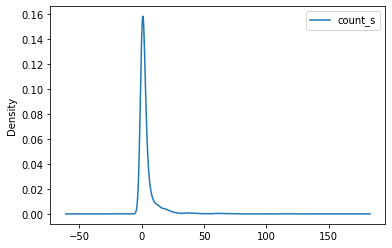

In [19]:
pddf = by_count.toPandas()
pddf.plot(kind="kde")

In [20]:
show_sentences("lc7uaw")

+------+-----+-----+----------------------------------------------------------------------------------------------------+
|    id|num_s|len_s|                                                                                            sentence|
+------+-----+-----+----------------------------------------------------------------------------------------------------+
|lc7uaw|    0|   25|                                                                           GME and why do we matter.|
|lc7uaw|    1|   47|                                                     I fling poop and drag my knuckles on the floor.|
|lc7uaw|    2|   29|                                                                       I am not a financial advisor.|
|lc7uaw|    3|   26|                                                                          Do your own due diligence.|
|lc7uaw|    4|   40|                                                            This is for entertainment purposes only.|
|lc7uaw|    5|  125|Late

In [21]:
show_sentences("l7o2rq")

+------+-----+-----+----------------------------------------------------------------------------------------------------+
|    id|num_s|len_s|                                                                                            sentence|
+------+-----+-----+----------------------------------------------------------------------------------------------------+
|l7o2rq|    0|   81|                   Know Thy Enemy Kenneth C. Griffin, the Barbarian Behind the Gates of the Citadel.|
|l7o2rq|    1|  134|, I have returned to inflict more psychic damage upon you about the sick fucks that make up the w...|
|l7o2rq|    2|  457|Today, I would like to talk to you about Kenneth Cordele Griffin the founder and CEO of a little ...|
|l7o2rq|    3|  334|Seeing as how there's a few million more of you here now than there were last month when I was em...|
|l7o2rq|    4|   96|    I do hope you take the time to read the full posts, because you may learn something interesting.|
|l7o2rq|    5|   11|    

---
## Takeaways:
  - most sentences are < 30 lines long (and even < 15?).
  - some people just write enormously long run-on sentences.
  - really short senteces often seem worth keeping (e.g., "HOLD" etc).
  - Could try to disambiguate stock names as in "GME" |-> "The publicly-traded stock GME".
  - Could concatenate sentences to aim for sentences around some length.
  - Could do two layers of sentence splitting: one for paragraphs and one for splitting long paragraphs.
  - the style "Exemplified. Here. By. This. String." could be handled as a special case? Probably not worth it.
  
 To do
  - ✓ check on quotation escaping.
  - ✓ split sentences on linebreaks (so keep these in DocumentNormalizer)
  - ✓ split sentenceson -'s
  - look again at asterisks.
  - ✓ improve ellipsis handling.


# Round 2: Change document processing 

In [299]:
# the format of the reddit data is that the string columns
# are wrapped in "s, and that internal quotes have are 
# wrapped in ""s or 's. We need to format our text here
# properly to match that.
text_list = [
    "\"YO💎 🙌\n\n -YO\n\n-YO\"",
    "\"Yo\n\n *YO 'what's up' \n\n *YO\"",
    "hey       hey      hey.",
    "🚀...🚀... 🚀 ... ",
    "\"Mo shouldn't sell 💎 🙌 should not sell.\"",
    "\"He said to me 'Sir, yes Sir!'.\"",
    "\"I said \"\"No Siree!\"\".\"",
    "Some quotes “are like this”.",
    "\"I paid a steep $5🚀🚀🚀. \n What say you??\"",
    " . ",
    ". . . . ..", 
    ". ... ... ...",
    "\"Don't sell GME, I say.. I don't sell.\"",
    "\"He's a seller.... I do not sell!\"",
    "\"i'm gonna sell. .......... I should sell!\"",
]

with open("eg_texts.csv", "w") as fobj:
    fobj.write("id\ttext\n")
    for idx, s in enumerate(text_list):
        fobj.write("\t".join([str(idx), s+"\n"]))
        
eg_df = spark.read.csv("eg_texts.csv",
                    header=True,
                    multiLine=True,
                    sep="\t",
                    inferSchema=True,
                    quote="\"",
                    escape="\""
                      )
eg_df.show(truncate=80)
texts = (
    embedding_pipeline.preprocess_texts(eg_df)
)
texts.show(truncate=1000)

+---+-----------------------------------------+
| id|                                     text|
+---+-----------------------------------------+
|  0|                       YO💎 🙌

 -YO

-YO|
|  1|              Yo

 *YO 'what's up' 

 *YO|
|  2|                  hey       hey      hey.|
|  3|                       🚀...🚀... 🚀 ... |
|  4| Mo shouldn't sell 💎 🙌 should not sell.|
|  5|           He said to me 'Sir, yes Sir!'.|
|  6|                      I said "No Siree!".|
|  7|             Some quotes “are like this”.|
|  8|I paid a steep $5🚀🚀🚀. 
 What say you??|
|  9|                                       . |
| 10|                               . . . . ..|
| 11|                            . ... ... ...|
| 12|    Don't sell GME, I say.. I don't sell.|
| 13|         He's a seller.... I do not sell!|
| 14|i'm gonna sell. .......... I should sell!|
+---+-----------------------------------------+

+---+------------------------------------------+
| id|                                      text|

In [298]:
pipeline = embedding_pipeline.build_embedding_preproc_pipeline()

pipeline_model = pipeline.fit(texts)
light_model = LightPipeline(pipeline_model)
def process_texts():
    processed_texts = light_model.transform(texts)
    return processed_texts
%time processed_texts = process_texts()
print(f"Processed (and counted) {df.count()} rows.")

ddf = (
    processed_texts
    .withColumn("num_s",
                processed_texts["finished_sentences_metadata"][0]._2
               .cast(T.IntegerType()))
    .withColumn("len_s",
                F.length(processed_texts["finished_sentences"][0])
                .cast(T.IntegerType()))
    .select("id", 
            "num_s",
            "len_s",
            F.col("finished_sentences")[0]
            .alias("sentence"))
)

ddf.show(truncate=False)

CPU times: user 17.8 ms, sys: 1.57 ms, total: 19.3 ms
Wall time: 120 ms
Processed (and counted) 2624 rows.
+---+-----+-----+------------------------------+
|id |num_s|len_s|sentence                      |
+---+-----+-----+------------------------------+
|0  |0    |3    |YO.                           |
|0  |1    |3    |YO.                           |
|1  |0    |3    |Yo.                           |
|1  |1    |16   |YO 'what's up' .              |
|2  |0    |12   |hey hey hey.                  |
|4  |0    |19   |Mo shouldn't sell .           |
|4  |1    |16   |should not sell.              |
|5  |0    |30   |He said to me 'Sir, yes Sir!'.|
|6  |0    |19   |I said "No Siree!".           |
|7  |0    |28   |Some quotes "are like this".  |
|8  |0    |18   |I paid a steep $5.            |
|8  |1    |14   |What say you??                |
|12 |0    |22   |Don't sell GME, I say.        |
|12 |1    |13   |I don't sell.                 |
|13 |0    |14   |He's a seller.                |
|13 |1    |

In [296]:
by_count = (ddf
            .select("id", 
                    F.col("num_s"))
            .groupby("id")
            .agg(F.max(F.col("num_s"))
                 .cast(T.IntegerType())
                 .alias("count_s"))
            .orderBy("count_s", ascending=False))
by_count.show()

+---+-------+
| id|count_s|
+---+-------+
| 12|      1|
| 13|      1|
| 14|      1|
|  1|      1|
|  8|      1|
|  4|      1|
|  0|      1|
|  6|      0|
|  5|      0|
|  2|      0|
|  7|      0|
+---+-------+



## Now look at the real data.

In [5]:
%%time
df = spark.read.csv(DATA_PATH, 
                    header=True,
                    multiLine=True, 
                    inferSchema=True,
                    quote="\"",
                    escape="\"")

df = df.sample(withReplacement=False, fraction=0.1, seed=1)

df = (df.withColumn("text", 
               F.concat_ws(". ", df.title, df.body))
      .drop("title", "body", "url", "comms_num", "created"))

CPU times: user 3.71 ms, sys: 4.6 ms, total: 8.31 ms
Wall time: 4.48 s


In [6]:
texts = (
    embedding_pipeline.preprocess_texts(df)
    .select("id", 
            "text")
)
pipeline = embedding_pipeline.build_embedding_preproc_pipeline()

pipeline_model = pipeline.fit(texts)
light_model = LightPipeline(pipeline_model)
def process_texts():
    processed_texts = light_model.transform(texts)
    return processed_texts
%time processed_texts = process_texts()
print(f"Processed (and counted) {df.count()} rows.")

CPU times: user 16.2 ms, sys: 3.25 ms, total: 19.5 ms
Wall time: 341 ms
Processed (and counted) 2624 rows.


In [7]:
ddf = (
    processed_texts
    .withColumn("num_s",
                processed_texts["finished_sentences_metadata"][0]._2
               .cast(T.IntegerType()))
    .withColumn("len_s",
                F.length(processed_texts["finished_sentences"][0])
                .cast(T.IntegerType()))
    .select("id", 
            "num_s",
            "len_s",
            F.col("finished_sentences")[0]
            .alias("sentence")))

Which posts have the longests sentenecs?

In [8]:
by_count = (ddf
            .select("id", 
                    F.col("num_s"))
            .groupby("id")
            .agg(F.max(F.col("num_s"))
                 .cast(T.IntegerType())
                 .alias("count_s"))
            .orderBy("count_s", ascending=False))
by_count.show(5)

+------+-------+
|    id|count_s|
+------+-------+
|lc7uaw|    122|
|l7o2rq|    116|
|lbaktb|    114|
|lbieij|    107|
|lamwg6|    103|
+------+-------+
only showing top 5 rows



In [9]:
def show_sentences(rowid):
    print("\n")
    (ddf
     .where(f"id=='{rowid}'")
     .select("id", "num_s", "len_s", "sentence")
     .show(150, truncate=100))
    print(df.where(f"id=='{rowid}'").toPandas().text.iloc[0])
    print("\n")

In [10]:
show_sentences("l7o2rq")
show_sentences("lamwg6")
show_sentences("lbieij")
show_sentences("lahttc")
show_sentences("lc7uaw")



+------+-----+-----+----------------------------------------------------------------------------------------------------+
|    id|num_s|len_s|                                                                                            sentence|
+------+-----+-----+----------------------------------------------------------------------------------------------------+
|l7o2rq|    0|   81|                   Know Thy Enemy Kenneth C. Griffin, the Barbarian Behind the Gates of the Citadel.|
|l7o2rq|    1|  132|I have returned to inflict more psychic damage upon you about the sick fucks that make up the wor...|
|l7o2rq|    2|  125|Today, I would like to talk to you about Kenneth Cordele Griffin the founder and CEO of a little ...|
|l7o2rq|    3|  333|Now unless you have been living under a fucking rock for the past week or have drank yourself to ...|
|l7o2rq|    4|  334|Seeing as how there's a few million more of you here now than there were last month when I was em...|
|l7o2rq|    5|   96|  

---
Looks good overall. It's tempting to try to handle the sectioning that some authors use with asteriskthe s, but That's probably best left as a refinement for later.

# Output for future processing

In [33]:
%%time
df = spark.read.csv(DATA_PATH, 
                    header=True,
                    multiLine=True, 
                    inferSchema=True,
                    quote="\"",
                    escape="\"")
# df = df.sample(withReplacement=False, fraction=0.1, seed=2)
df = (df.withColumn("text", 
               F.concat_ws(". ", df.title, df.body))
      .drop("title", "body", "url", "comms_num", "created"))

texts = (
    embedding_pipeline.preprocess_texts(df)
)
pipeline = embedding_pipeline.build_embedding_preproc_pipeline()

pipeline_model = pipeline.fit(texts)
light_model = LightPipeline(pipeline_model)
def process_texts():
    processed_texts = light_model.transform(texts)
    return processed_texts
%time processed_texts = process_texts()
print(f"Processed (and counted) {df.count()} rows.")



out_df = (
    processed_texts
    .withColumn("num_s",
                processed_texts["finished_sentences_metadata"][0]._2)
    .withColumn("len_s",
                F.length(processed_texts["finished_sentences"][0]))
    .select("id", 
            "num_s",
            "len_s",
            F.col("finished_sentences")[0]
            .alias("sentence"))
)
# out_df.show(50, truncate=80)



day, time = str(datetime.now()).split()
time = time.split(".")[0]
timestamp = "_".join([day, time])
OUTPUT_DIR = f"../data/sentences_{timestamp}"
out_df.write.csv(OUTPUT_DIR, header=True, sep="\t")
print(f"Wrote csv file inside {OUTPUT_DIR}")

CPU times: user 6.4 ms, sys: 5.84 ms, total: 12.2 ms
Wall time: 64.9 ms
Processed (and counted) 25647 rows.
Wrote csv file inside ../data/sentences_2021-03-02_17:07:51
CPU times: user 40.1 ms, sys: 11.1 ms, total: 51.2 ms
Wall time: 28.3 s


Write to CSV (but use tab as delimiter).

# Process with Tensorflow

In [2]:
DATA_PATH = f"../data/sentences_2021-03-02_17:07:51/part*"
! head {DATA_PATH}

id	num_s	len_s	sentence
l6ulcx	0	55	It's not about the money, it's about sending a message.
l6uibd	0	80	Math Professor Scott Steiner says the numbers spell DISASTER for Gamestop shorts
l6uhhn	0	16	Exit the system.
l6uhhn	1	101	"The CEO of NASDAQ pushed to halt trading \"to give investors a chance to recalibrate their positions\"."
l6uhhn	2	68	Now SEC is investigating, brokers are disallowing buying more calls.
l6uhhn	3	180	"This is the institutions flat out admitting they will change the rules to bail out the rich but if it happens to us, we get a \"well shucks you should have known investing is risky!"
l6uhhn	4	79	"have you tried cutting out avocados and coffee, maybe doing Uber on the side?\"."
l6uhhn	5	184	We may have collectively driven up enough sentiment in wall street to make other big players go long on GME with us we do not have the money to move the stock as much as it did alone .
l6uhhn	6	130	we didn't hurt wall street as a whole, just a few funds went down while others went

In [3]:
ds = (tf.data.experimental.make_csv_dataset(
    DATA_PATH,
    batch_size=8, 
    field_delim="\t",
    shuffle=False,
    header=True,
    column_defaults=[tf.string, tf.int32, tf.int32, tf.string],
    use_quote_delim=False))
ds

<PrefetchDataset shapes: OrderedDict([(id, (8,)), (num_s, (8,)), (len_s, (8,)), (sentence, (8,))]), types: OrderedDict([(id, tf.string), (num_s, tf.int32), (len_s, tf.int32), (sentence, tf.string)])>

In [4]:
%%time
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder-cmlm/en-base/1")

CPU times: user 8.45 s, sys: 684 ms, total: 9.14 s
Wall time: 9.12 s


In [5]:
emb = encoder(preprocessor(["here is an example sentence"]))
print(type(emb), emb.keys())
boolean = np.all(emb['default'] == emb['pooled_output'])
print(f"np.all(emb['default'] == emb['pooled_output']) is {boolean}")

<class 'dict'> dict_keys(['pooled_output', 'sequence_output', 'default'])
np.all(emb['default'] == emb['pooled_output']) is True


In [46]:
out_ds = (ds.take(2)
          .map(lambda t: (t, encoder(preprocessor(t['sentence']))['pooled_output'])))

In [85]:
%%time 
reducer = umap.UMAP(random_state=1)
sentences = []
Z = []
for t, X in out_ds:
    sentences += [t['sentence'].numpy().astype(np.str)]
    new_points = reducer.fit_transform(X)
    Z += [new_points]
sentences = np.concatenate(sentences)
Z = np.concatenate(Z)

/home/cody/anaconda3/lib/python3.7/site-packages/umap/umap_.py:2214: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1

/home/cody/anaconda3/lib/python3.7/site-packages/umap/umap_.py:2214: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



CPU times: user 28.6 s, sys: 96 ms, total: 28.7 s
Wall time: 10.9 s


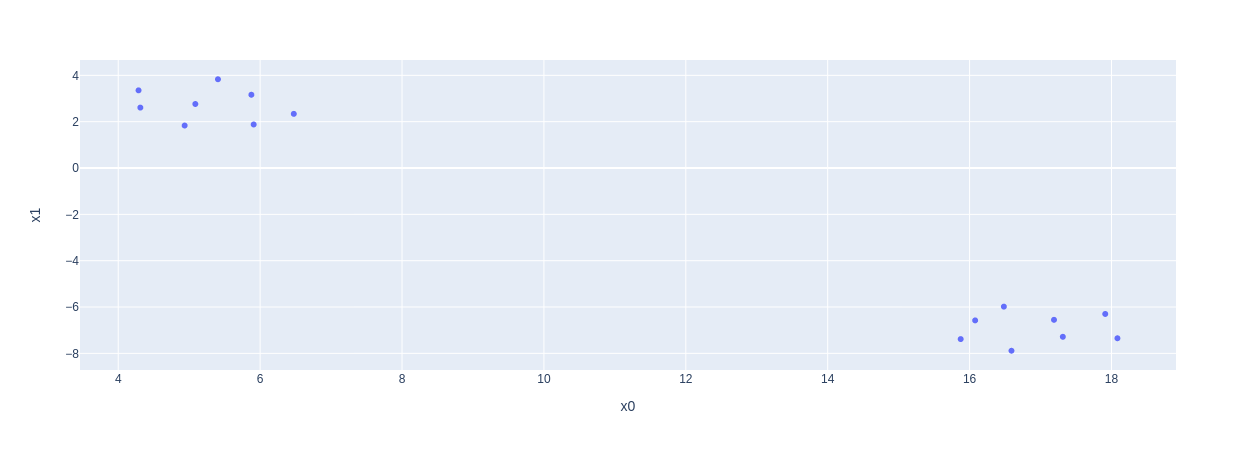

In [91]:
gdf = (
    pd.DataFrame(Z, columns=["x0", "x1"])
).assign(text=sentences)

hover_dict = {"text":True}

fig = px.scatter(gdf, x="x0", y="x1", hover_data=hover_dict)
fig.show()

# Scratch: using petastorm for interface Spark <-> Tensorflow
Petastorm is one way to avoid outputing the cleaned data to disk and then reimporting. It writes the files to parquet and gives a fast interface to tensorflow. Probably it is more trouble than it's worth (and a tweak is needed for TF2.x?) at the moment?

In [44]:
# I also looked at using TFRecords, but it seemed
# like it might be a pain to integrate the tf-spark
# connector with Spark NLP.

try:
    import petastorm
except ModuleNotFoundError:
    ! pip install petastorm==0.9.8
    import petastorm
    
from petastorm.spark import (SparkDatasetConverter, 
                             make_spark_converter)

import tensorflow.compat.v1 as tf

In [28]:
%%time
CACHE_DIR = f"{os.environ['PWD']}/data/cache/"
spark.conf.set(SparkDatasetConverter.PARENT_CACHE_DIR_URL_CONF,
               f"file://{CACHE_DIR}")
# this writes the parquet file(s)
converter = make_spark_converter(out_df)
# with this context, we have access to an object of type
# tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter
dataset_context_manager = converter.make_tf_dataset()

CPU times: user 34.7 ms, sys: 10.7 ms, total: 45.4 ms
Wall time: 364 ms


In [43]:
with dataset_context_manager as dataset:
    print(dataset, "\n")
    for batch in dataset.take(1):
        print(batch)

<DatasetV1Adapter shapes: inferred_schema_view(id=(None,), timestamp=(None,), sentence_num=(None,), sentence=(None,)), types: inferred_schema_view(id=tf.string, timestamp=tf.int64, sentence_num=tf.string, sentence=tf.string)> 

inferred_schema_view(id=<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'l6ulcx', b'l6uibd', b'l6uhhn', b'l6uhhn', b'l6uhhn', b'l6uhhn',
       b'l6uhhn', b'l6uhhn', b'l6uhhn', b'l6uhhn', b'l6uhhn', b'l6uhhn',
       b'l6uhhn', b'l6uhhn', b'l6uhhn', b'l6ugk6', b'l6ugk6', b'l6ufgy',
       b'l6uf7d', b'l6uf6d', b'l6uf6d', b'l6uf6d', b'l6uf6d', b'l6uf6d',
       b'l6uf6d', b'l6uf6d', b'l6uf6d', b'l6uf6d', b'l6uf6d', b'l6ub9l',
       b'l6ub9l', b'l6ub9l'], dtype=object)>, timestamp=<tf.Tensor: shape=(32,), dtype=int64, numpy=
array([1611887861000000000, 1611887530000000000, 1611887435000000000,
       1611887435000000000, 1611887435000000000, 1611887435000000000,
       1611887435000000000, 1611887435000000000, 1611887435000000000,
       1611887435000000000